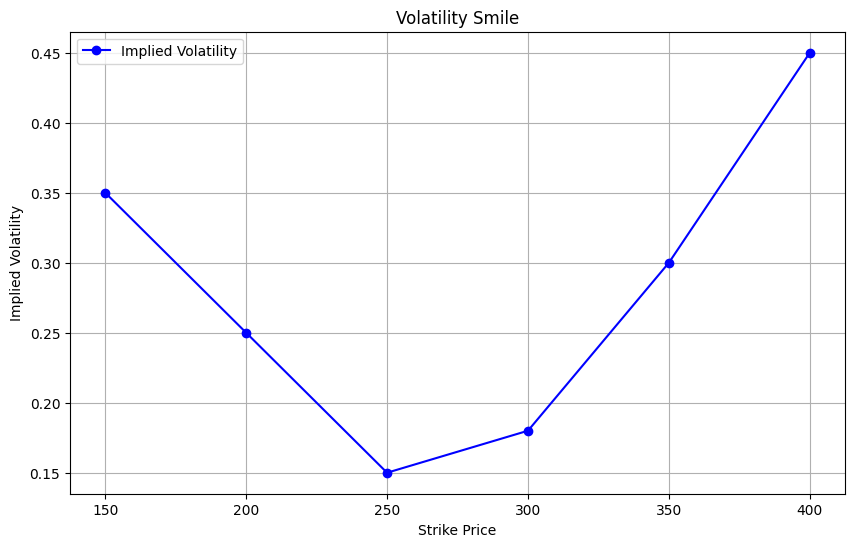

In [2]:
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt

# Black-Scholes formula for European call option price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    return call_price

# Vega of the call option (derivative of price with respect to volatility)
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * si.norm.pdf(d1) * np.sqrt(T)

# Newton-Raphson method to compute implied volatility
def implied_volatility_newton(S, K, T, r, market_price, tol=1e-8, max_iter=100):
    sigma = 0.2  # Initial guess for volatility
    for i in range(max_iter):
        price = black_scholes_call(S, K, T, r, sigma)
        vega_value = vega(S, K, T, r, sigma)

        # Safeguard against division by zero or very small vega values
        if vega_value < 1e-8:
            vega_value = 1e-8

        price_diff = price - market_price

        # Check for convergence
        if abs(price_diff) < tol:
            return sigma

        # Update sigma
        sigma -= price_diff / vega_value

        # Ensure sigma stays within reasonable bounds
        if sigma < 0:
            sigma = 0.01  # Minimum volatility constraint to avoid division by zero

    raise ValueError("Newton-Raphson method did not converge within the maximum iterations")

# Parameters for the plot
S = 250  # Current stock price
T = 1    # Time to maturity (1 year)
r = 0.05  # Risk-free interest rate (5%)
strikes = np.arange(100, 450, 50)  # Range of strike prices


# Generate hypothetical market prices with more extreme variations to replicate the original smile
true_volatilities = [0.5, 0.35, 0.25, 0.15, 0.18, 0.3, 0.45]  # Increased variations for a more pronounced smile
market_prices = [black_scholes_call(S, K, T, r, sigma) for K, sigma in zip(strikes, true_volatilities)]

# Calculate implied volatilities for different strike prices
implied_vols = []
for K, market_price in zip(strikes, market_prices):
    try:
        iv = implied_volatility_newton(S, K, T, r, market_price)
        implied_vols.append(iv)
    except ValueError:
        implied_vols.append(np.nan)  # Append NaN if convergence fails

# Plotting the volatility smile
plt.figure(figsize=(10, 6))
plt.plot(strikes, implied_vols, marker='o', linestyle='-', color='b', label='Implied Volatility')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Volatility Smile')
plt.grid(True)
plt.legend()
plt.show()


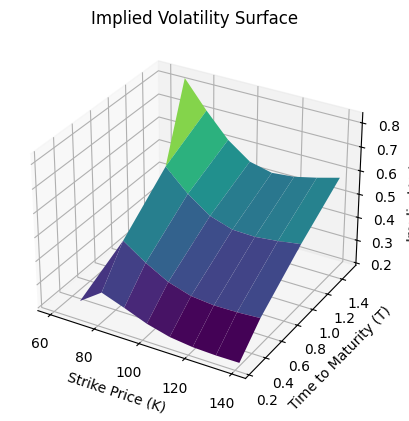

In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
import matplotlib.pyplot as plt

# Given data
S = 100  # Current index price
r = 0.03  # Interest rate
strikes = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140])
maturities = np.array([0.25, 0.5, 1.0, 1.5])
call_prices = np.array([
    [40.2844, 42.4249, 50.8521, 59.1664],
    [30.5281, 33.5355, 42.6656, 51.2181],
    [21.0415, 24.9642, 34.4358, 42.9436],
    [12.2459, 16.9652, 26.4453, 34.7890],
    [5.2025, 10.1717, 19.4706, 27.8938],
    [1.3448, 5.4318, 14.4225, 23.3305],
    [0.2052, 2.7647, 11.2103, 20.7206],
    [0.0216, 1.4204, 9.1497, 19.1828],
    [0.0019, 0.7542, 7.7410, 18.1858]
])

# Black-Scholes Call Option Pricing Formula
def black_scholes_call(S, K, T, r, sigma):
    if sigma <= 0 or T <= 0:
        return np.nan  # Return NaN for non-positive sigma or T

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Vega function: derivative of call price with respect to volatility
def vega(S, K, T, r, sigma):
    if sigma <= 0 or T <= 0:
        return np.nan  # Return NaN for non-positive sigma or T

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

# Implied volatility using Newton-Raphson method
def implied_volatility_newton(C_market, S, K, T, r, tol=1e-6, max_iter=100):
    sigma = 0.2  # Initial guess for volatility
    epsilon = 1e-8  # Small epsilon to prevent division by zero

    for i in range(max_iter):
        price = black_scholes_call(S, K, T, r, sigma)
        vega_value = vega(S, K, T, r, sigma)
        
        # Check for valid vega_value to avoid division by zero
        if np.isnan(price) or np.isnan(vega_value) or vega_value < epsilon:
            return np.nan

        price_diff = price - C_market
        
        # Update step
        sigma_new = sigma - price_diff / vega_value
        
        # Check for convergence
        if abs(sigma_new - sigma) < tol:
            return sigma_new
        
        sigma = sigma_new

    # If convergence not reached, return NaN
    return np.nan

# Compute implied volatilities using Newton-Raphson
implied_vols = np.zeros(call_prices.shape)

for i, K in enumerate(strikes):
    for j, T in enumerate(maturities):
        implied_vols[i, j] = implied_volatility_newton(call_prices[i, j], S, K, T, r)

# Plotting the volatility surface without interpolation
K_grid, T_grid = np.meshgrid(strikes, maturities)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(K_grid, T_grid, implied_vols.T, cmap='viridis')
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')

plt.show()

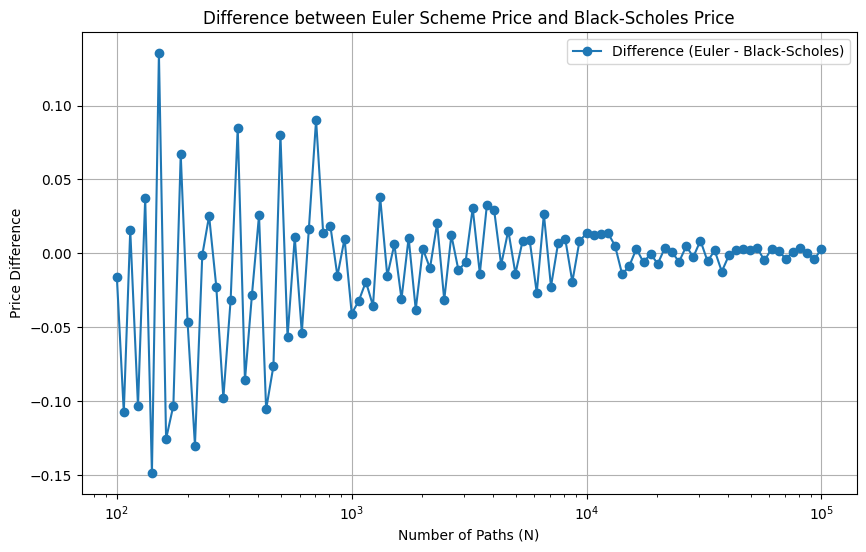

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 5      # Initial stock price
K = S0      # Strike price (ATM option)
sigma = 0.3 # Volatility
r = 0.06    # Risk-free rate
T = 1.0     # Time to maturity
m = 1000    # Number of time steps
dt = T / m  # Time step size

# Generate a range of N values for more plot points
N_values = np.logspace(2, 5, num=100, dtype=int)  # 100 points from 10^2 to 10^5

# Black-Scholes analytical price for European call option
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

bs_call_price = black_scholes_call(S0, K, T, r, sigma)

# Monte Carlo simulation using Euler scheme for European call option
def monte_carlo_euler(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z)

    # Payoff for European call option
    payoffs = np.maximum(S_paths[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Compute the differences for different N values
euler_differences = []

for N in N_values:
    euler_price = monte_carlo_euler(S0, K, T, r, sigma, N, m)
    difference = euler_price - bs_call_price
    euler_differences.append(difference)

# Plot results: Difference between Euler scheme price and Black-Scholes price
plt.figure(figsize=(10, 6))
plt.plot(N_values, euler_differences, marker='o', linestyle='-', label='Difference (Euler - Black-Scholes)')
plt.xlabel('Number of Paths (N)')
plt.ylabel('Price Difference')
plt.title('Difference between Euler Scheme Price and Black-Scholes Price')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()


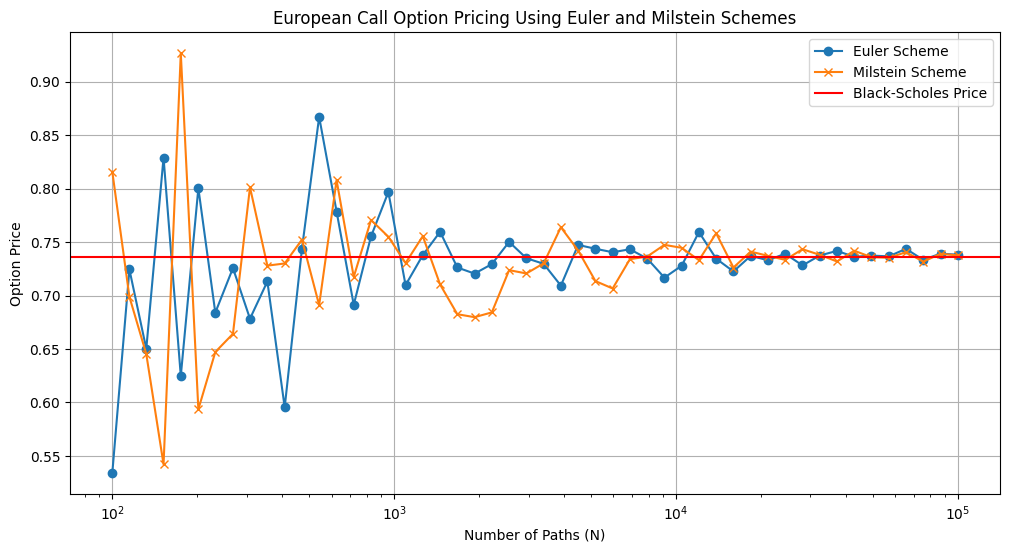

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 5      # Initial stock price
K = S0      # Strike price (ATM option)
sigma = 0.3 # Volatility
r = 0.06    # Risk-free rate
T = 1.0     # Time to maturity
m = 1000    # Number of time steps
dt = T / m  # Time step size

# Generate a finer range of N values for more plot points
N_values = np.logspace(2, 5, num=50, dtype=int)  # 50 points from 10^2 to 10^5

# Black-Scholes analytical price for European call option
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

bs_call_price = black_scholes_call(S0, K, T, r, sigma)

# Monte Carlo simulation using Euler scheme
def monte_carlo_euler(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z)

    payoffs = np.maximum(S_paths[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Monte Carlo simulation using Milstein scheme
def monte_carlo_milstein(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z + 0.5 * sigma**2 * dt * (Z**2 - 1))

    payoffs = np.maximum(S_paths[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Compute prices for different N values
euler_call_prices = []
milstein_call_prices = []

for N in N_values:
    euler_price = monte_carlo_euler(S0, K, T, r, sigma, N, m)
    milstein_price = monte_carlo_milstein(S0, K, T, r, sigma, N, m)
    euler_call_prices.append(euler_price)
    milstein_call_prices.append(milstein_price)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(N_values, euler_call_prices, label='Euler Scheme', marker='o')
plt.plot(N_values, milstein_call_prices, label='Milstein Scheme', marker='x')
plt.axhline(y=bs_call_price, color='r', linestyle='-', label='Black-Scholes Price')
plt.xlabel('Number of Paths (N)')
plt.ylabel('Option Price')
plt.title('European Call Option Pricing Using Euler and Milstein Schemes')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()


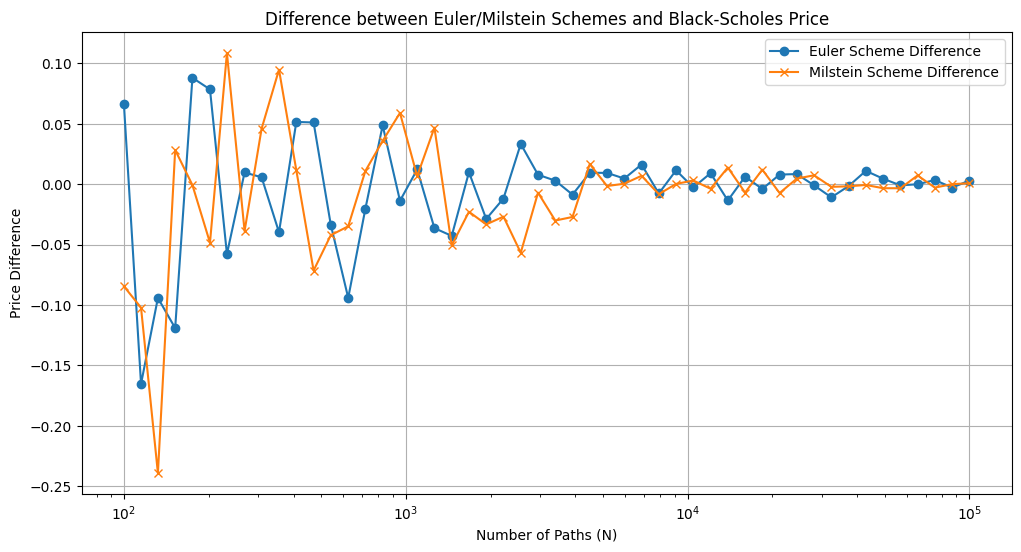

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 5      # Initial stock price
K = S0      # Strike price (ATM option)
sigma = 0.3 # Volatility
r = 0.06    # Risk-free rate
T = 1.0     # Time to maturity
m = 1000    # Number of time steps
dt = T / m  # Time step size

# Generate a finer range of N values for more plot points
N_values = np.logspace(2, 5, num=50, dtype=int)  # 50 points from 10^2 to 10^5

# Black-Scholes analytical price for European call option
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

bs_call_price = black_scholes_call(S0, K, T, r, sigma)

# Monte Carlo simulation using Euler scheme
def monte_carlo_euler(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z)

    payoffs = np.maximum(S_paths[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Monte Carlo simulation using Milstein scheme
def monte_carlo_milstein(S0, K, T, r, sigma, N, m):
    dt = T / m
    S_paths = np.zeros((m + 1, N))
    S_paths[0] = S0

    for t in range(1, m + 1):
        Z = np.random.standard_normal(N)
        S_paths[t] = S_paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * Z + 0.5 * sigma**2 * dt * (Z**2 - 1))

    payoffs = np.maximum(S_paths[-1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    return price

# Compute prices and differences for different N values
euler_call_prices = []
milstein_call_prices = []
euler_differences = []
milstein_differences = []

for N in N_values:
    euler_price = monte_carlo_euler(S0, K, T, r, sigma, N, m)
    milstein_price = monte_carlo_milstein(S0, K, T, r, sigma, N, m)
    euler_call_prices.append(euler_price)
    milstein_call_prices.append(milstein_price)
    
    # Calculate differences from the Black-Scholes price
    euler_diff = euler_price - bs_call_price
    milstein_diff = milstein_price - bs_call_price
    euler_differences.append(euler_diff)
    milstein_differences.append(milstein_diff)
    
  

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(N_values, euler_differences, label='Euler Scheme Difference', marker='o')
plt.plot(N_values, milstein_differences, label='Milstein Scheme Difference', marker='x')
plt.xlabel('Number of Paths (N)')
plt.ylabel('Price Difference')
plt.title('Difference between Euler/Milstein Schemes and Black-Scholes Price')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()


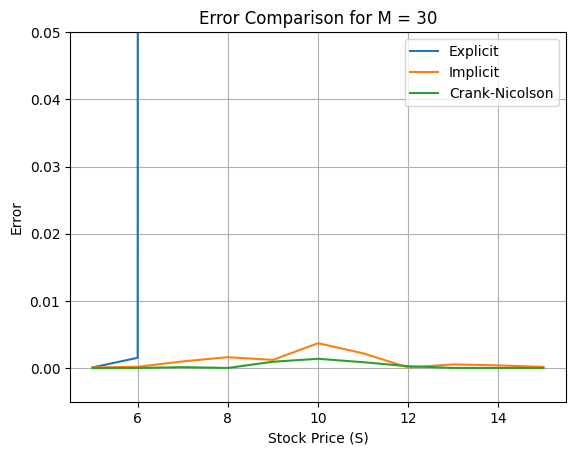

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit Finite Difference Method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Explicit Method
    alpha = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 - dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + beta * V[1:N] + gamma * V[2:N+1]
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Implicit Finite Difference Method
def implicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Implicit Method
    alpha = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)

    for j in range(M):
        V[1:N] = np.linalg.solve(A, V[1:N])
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Crank-Nicolson Finite Difference Method
def crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Crank-Nicolson Method
    alpha = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))

    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    B = np.diag(-alpha[1:], -1) + np.diag(2 - beta) + np.diag(-gamma[:-1], 1)

    for j in range(M):
        V[1:N] = np.linalg.solve(A, np.dot(B, V[1:N]))
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Parameters
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
sigma = 0.2       # Volatility
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 16, 1)  # Stock price range S = {5, 6, ..., 15}

# Specified values for N and M
N = 100
M = 30

# Lists to store errors
errors_explicit = []
errors_implicit = []
errors_crank = []

# Calculating errors for different methods
for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit.append(abs(bs_price - price_explicit))
    errors_implicit.append(abs(bs_price - price_implicit))
    errors_crank.append(abs(bs_price - price_crank))

# Plotting Error Comparisons
plt.plot(S_values, errors_explicit, label='Explicit')
plt.plot(S_values, errors_implicit, label='Implicit')
plt.plot(S_values, errors_crank, label='Crank-Nicolson')
plt.title('Error Comparison for M = 30')
plt.xlabel('Stock Price (S)')
plt.ylabel('Error')
plt.ylim(-0.005, 0.05)  # Set y-axis range from -0.005 to 0.05
plt.legend()
plt.grid(True)
plt.show()

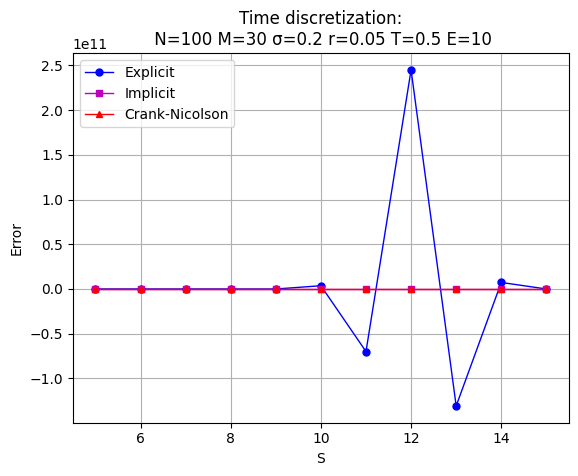

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit Finite Difference Method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Explicit Method
    alpha = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 - dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + beta * V[1:N] + gamma * V[2:N+1]
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Implicit Finite Difference Method
def implicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Implicit Method
    alpha = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)

    for j in range(M):
        V[1:N] = np.linalg.solve(A, V[1:N])
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Crank-Nicolson Finite Difference Method
def crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Crank-Nicolson Method
    alpha = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))

    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    B = np.diag(-alpha[1:], -1) + np.diag(2 - beta) + np.diag(-gamma[:-1], 1)

    for j in range(M):
        V[1:N] = np.linalg.solve(A, np.dot(B, V[1:N]))
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Parameters
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
sigma = 0.2       # Volatility
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 16, 1)  # Stock price range S = {5, 6, ..., 15}

# Specified values for N and M
N = 100
M = 30

# Lists to store errors
errors_explicit = []
errors_implicit = []
errors_crank = []

# Calculating errors for different methods
for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit.append(bs_price - price_explicit)
    errors_implicit.append(bs_price - price_implicit)
    errors_crank.append(bs_price - price_crank)

# Plotting Error Comparisons
plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=5)
plt.title('Time discretization:\n N=100 M=30 σ=0.2 r=0.05 T=0.5 E=10')
plt.xlabel('S')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

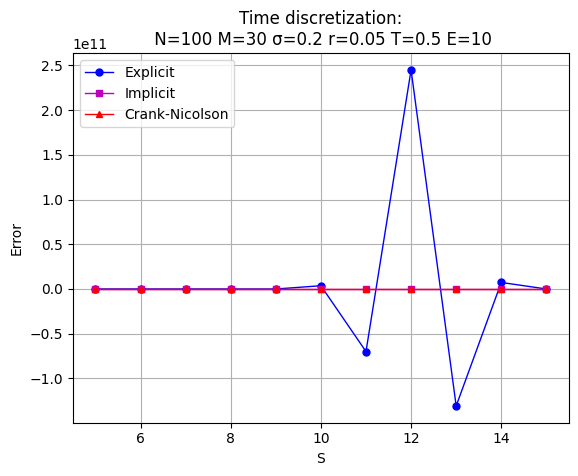

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit Finite Difference Method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Explicit Method
    alpha = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 - dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + beta * V[1:N] + gamma * V[2:N+1]
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Implicit Finite Difference Method
def implicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Implicit Method
    alpha = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)

    for j in range(M):
        V[1:N] = np.linalg.solve(A, V[1:N])
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Crank-Nicolson Finite Difference Method
def crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T

    # Coefficients for Crank-Nicolson Method
    alpha = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))

    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    B = np.diag(-alpha[1:], -1) + np.diag(2 - beta) + np.diag(-gamma[:-1], 1)

    for j in range(M):
        V[1:N] = np.linalg.solve(A, np.dot(B, V[1:N]))
        # Apply Boundary Conditions
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0

    return np.interp(S, S_grid, V)

# Parameters
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
sigma = 0.2       # Volatility
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 16, 1)  # Stock price range S = {5, 6, ..., 15}

# Specified values for N and M
N = 100
M = 30

# Lists to store errors
errors_explicit = []
errors_implicit = []
errors_crank = []

# Calculating errors for different methods
for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit.append(bs_price - price_explicit)
    errors_implicit.append(bs_price - price_implicit)
    errors_crank.append(bs_price - price_crank)

# Plotting Error Comparisons
plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=5)
plt.title('Time discretization:\n N=100 M=30 σ=0.2 r=0.05 T=0.5 E=10')
plt.xlabel('S')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

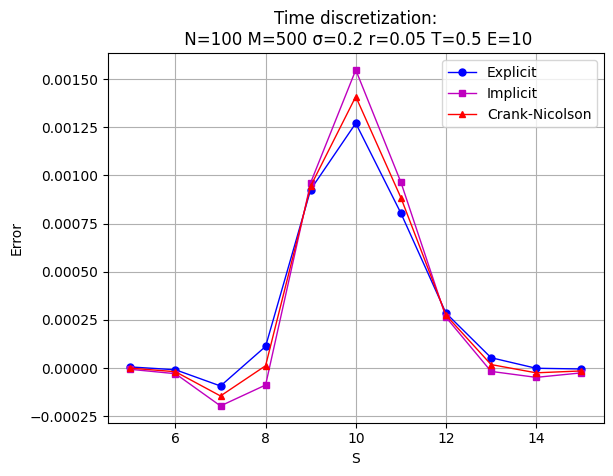

In [45]:
# Specified values for N and updated M
N = 100
M = 500  # Increased number of time steps

# Lists to store errors for new M
errors_explicit_M500 = []
errors_implicit_M500 = []
errors_crank_M500 = []

# Calculating errors for different methods with new M
for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit_M500.append(bs_price - price_explicit)
    errors_implicit_M500.append(bs_price - price_implicit)
    errors_crank_M500.append(bs_price - price_crank)

# Plotting Error Comparisons for M = 500
plt.plot(S_values, errors_explicit_M500, 'b-o', label='Explicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_implicit_M500, 'm-s', label='Implicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_crank_M500, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=5)
plt.title('Time discretization:\n N=100 M=500 σ=0.2 r=0.05 T=0.5 E=10')
plt.xlabel('S')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

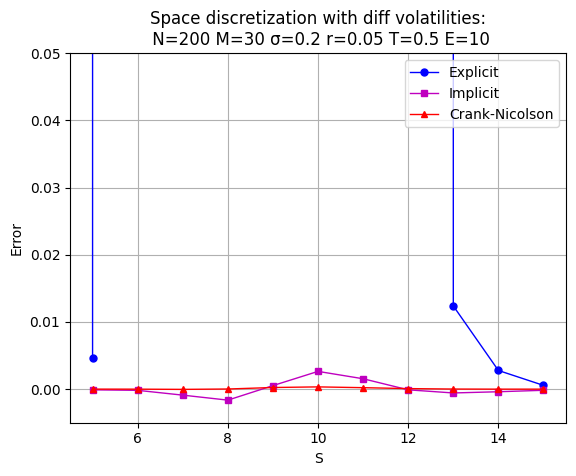

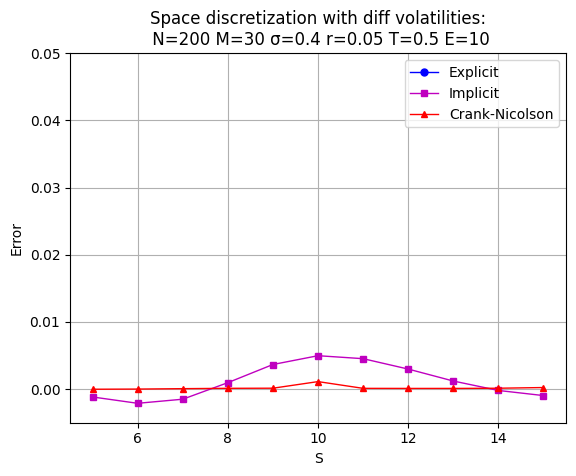

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = -dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + (1 + beta) * V[1:N] + gamma * V[2:N+1]
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
        
    return np.interp(S, S_grid, V)

# Implicit method
def implicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, V[1:N])
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
    
    return np.interp(S, S_grid, V)

# Crank-Nicholson method
def crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    B = np.diag(-alpha[1:], -1) + np.diag(2 - beta) + np.diag(-gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, np.dot(B, V[1:N]))
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
        
    return np.interp(S, S_grid, V)

# Define parameters
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 16, 1)  # Stock price range S = {5, 6, ..., 15}
N = 200           # Number of space steps
M = 30            # Number of time steps

# Different volatilities
sigma_values = [0.2, 0.4]

# Loop through both volatilities
for sigma in sigma_values:
    errors_explicit = []
    errors_implicit = []
    errors_crank = []
    
    for S in S_values:
        bs_price = black_scholes_put(S, E, T, r, sigma)
        price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
        price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
        price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
        
        errors_explicit.append(bs_price - price_explicit)
        errors_implicit.append(bs_price - price_implicit)
        errors_crank.append(bs_price - price_crank)
    
    # Plotting the errors for each volatility
    plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=5)
    plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=5)
    plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=5)
    plt.title(f'Space discretization with diff volatilities:\n N=200 M=30 σ={sigma} r=0.05 T=0.5 E=10')
    plt.xlabel('S')
    plt.ylabel('Error')
    plt.ylim(-0.005, 0.05)
    plt.legend()
    plt.grid(True)
    plt.show()

Black-Scholes Price: 0.4420
Explicit FD Price: -1734849084078197054162847399936.0000
Implicit FD Price: 0.4393
Crank-Nicolson Price: 0.4416


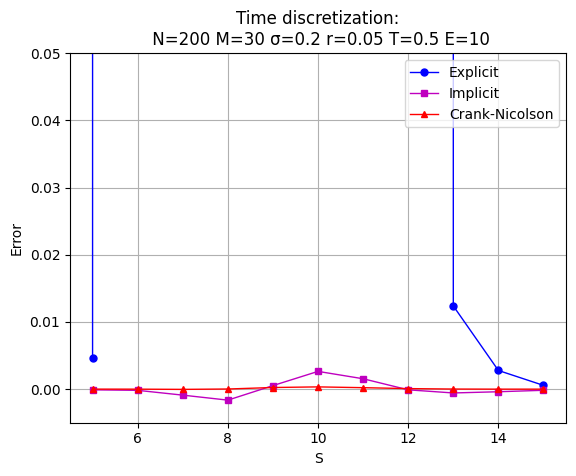

In [26]:
# Corrected Explicit method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    # Coefficients
    alpha = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = dt * (sigma**2 * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    # Time-stepping backwards
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + (1 - beta) * V[1:N] + gamma * V[2:N+1]
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
    
    return np.interp(S, S_grid, V)

# Test the revised explicit method along with the existing implicit and Crank-Nicolson methods
sigma = 0.2  # Volatility
S = 10  # Example stock price
bs_price = black_scholes_put(S, E, T, r, sigma)
price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)

print(f"Black-Scholes Price: {bs_price:.4f}")
print(f"Explicit FD Price: {price_explicit:.4f}")
print(f"Implicit FD Price: {price_implicit:.4f}")
print(f"Crank-Nicolson Price: {price_crank:.4f}")

# Plot the errors for the updated scheme
errors_explicit = []
errors_implicit = []
errors_crank = []

for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit.append(bs_price - price_explicit)
    errors_implicit.append(bs_price - price_implicit)
    errors_crank.append(bs_price - price_crank)

plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=5)
plt.title(f'Time discretization:\n N=200 M=30 σ={sigma} r=0.05 T=0.5 E=10')
plt.xlabel('S')
plt.ylabel('Error')
plt.ylim(-0.005, 0.05)
plt.legend()
plt.grid(True)
plt.show()

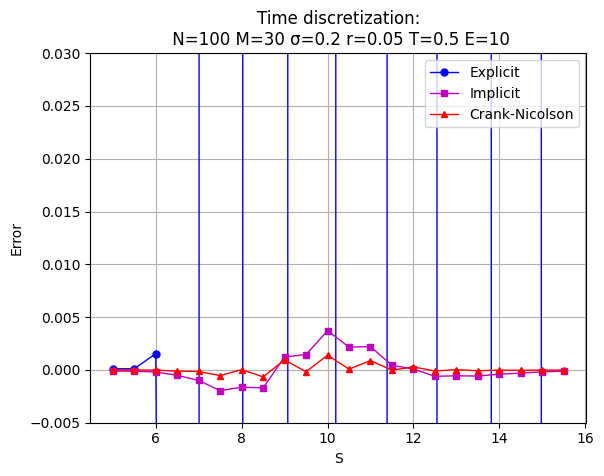

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    # Coefficients for explicit finite difference scheme
    alpha = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 - dt * (sigma**2 * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    # Time-stepping backwards
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + beta * V[1:N] + gamma * V[2:N+1]
        V[0] = E * np.exp(-r * dt * (j+1))  # Boundary condition at S=0
        V[-1] = 0  # Boundary condition at Smax
    
    return np.interp(S, S_grid, V)

# Implicit and Crank-Nicolson methods remain the same

# Plot the errors for the updated scheme
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
sigma = 0.2       # Volatility
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 16, 0.5)  # Stock price range S = {5, 6, ..., 15}
N = 100
M = 30

errors_explicit = []
errors_implicit = []
errors_crank = []

for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit.append(bs_price - price_explicit)
    errors_implicit.append(bs_price - price_implicit)
    errors_crank.append(bs_price - price_crank)

# Adjust plot to increase number of points and error range
plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=5)
plt.title(f'Time discretization:\n N=100 M=30 σ={sigma} r=0.05 T=0.5 E=10')
plt.xlabel('S')
plt.ylabel('Error')
plt.ylim(-0.005, 0.03)  # Adjust the y-axis for better visibility of errors
plt.legend()
plt.grid(True)
plt.show()

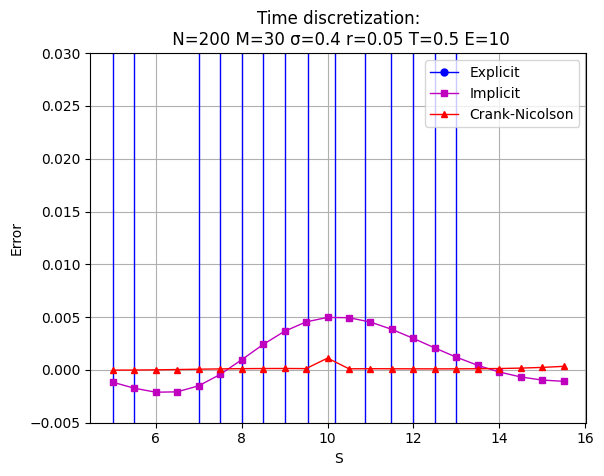

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    # Coefficients for explicit finite difference scheme
    alpha = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 - dt * (sigma**2 * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    # Time-stepping backwards
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + beta * V[1:N] + gamma * V[2:N+1]
        V[0] = E * np.exp(-r * dt * (j+1))  # Boundary condition at S=0
        V[-1] = 0  # Boundary condition at Smax
    
    return np.interp(S, S_grid, V)

# Implicit method
def implicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, V[1:N])
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
    
    return np.interp(S, S_grid, V)

# Crank-Nicholson method
def crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    B = np.diag(-alpha[1:], -1) + np.diag(2 - beta) + np.diag(-gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, np.dot(B, V[1:N]))
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
        
    return np.interp(S, S_grid, V)

# Define Parameters
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
sigma = 0.4       # Volatility increased to 0.4
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 16, 0.5)  # Stock price range S = {5, 6, ..., 15}
N = 200           # Increased number of space steps
M = 30            # Number of time steps

# Calculate Errors
errors_explicit = []
errors_implicit = []
errors_crank = []

for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit.append(bs_price - price_explicit)
    errors_implicit.append(bs_price - price_implicit)
    errors_crank.append(bs_price - price_crank)

# Plot Errors
plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=5)
plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=5)
plt.title(f'Time discretization:\n N={N} M={M} σ={sigma} r=0.05 T=0.5 E=10')
plt.xlabel('S')
plt.ylabel('Error')
plt.ylim(-0.005, 0.03)  # Adjust y-axis range for visibility
plt.legend()
plt.grid(True)
plt.show()

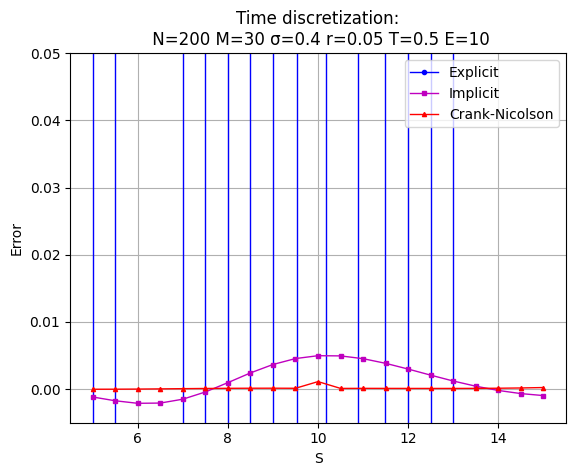

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    # Coefficients for explicit finite difference scheme
    alpha = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 - dt * (sigma**2 * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    # Time-stepping backwards
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + beta * V[1:N] + gamma * V[2:N+1]
        V[0] = E * np.exp(-r * dt * (j+1))  # Boundary condition at S=0
        V[-1] = 0  # Boundary condition at Smax
    
    return np.interp(S, S_grid, V)

# Implicit method
def implicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, V[1:N])
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
    
    return np.interp(S, S_grid, V)

# Crank-Nicholson method
def crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    B = np.diag(-alpha[1:], -1) + np.diag(2 - beta) + np.diag(-gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, np.dot(B, V[1:N]))
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
        
    return np.interp(S, S_grid, V)

# Define Parameters
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
sigma = 0.4       # Volatility increased to 0.4
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 15.1, 0.5)  # Stock price range S = {5, 5.1, ..., 15} with finer grid
N = 200           # Number of space steps
M = 30            # Number of time steps

# Calculate Errors
errors_explicit = []
errors_implicit = []
errors_crank = []

for S in S_values:
    bs_price = black_scholes_put(S, E, T, r, sigma)
    price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
    price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
    
    errors_explicit.append(bs_price - price_explicit)
    errors_implicit.append(bs_price - price_implicit)
    errors_crank.append(bs_price - price_crank)

# Plot Errors
plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=3)
plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=3)
plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=3)
plt.title(f'Time discretization:\n N={N} M={M} σ={sigma} r=0.05 T=0.5 E=10')
plt.xlabel('S')
plt.ylabel('Error')
plt.ylim(-0.005, 0.05)  # Adjust y-axis range for visibility
plt.legend()
plt.grid(True)
plt.show()

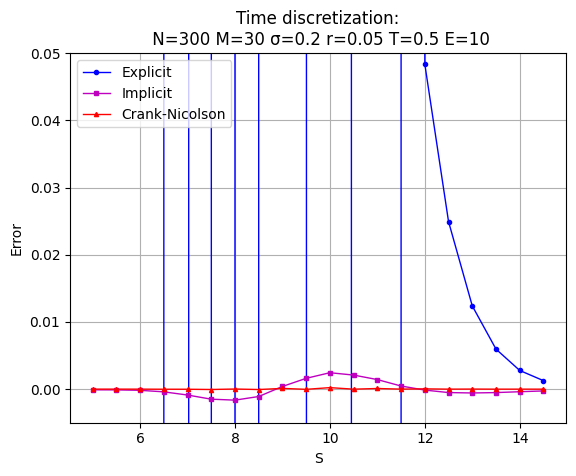

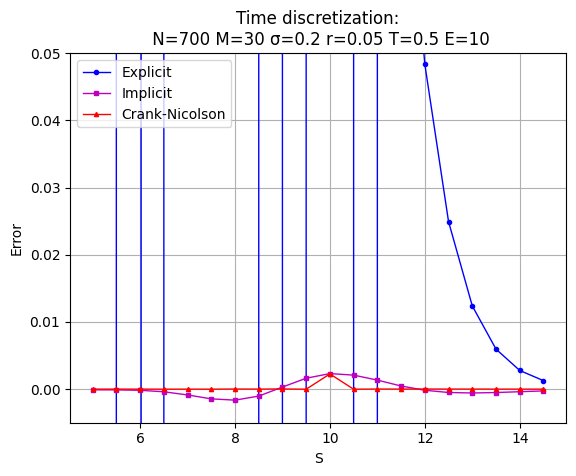

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the Black-Scholes formula for a European put option
def black_scholes_put(S, E, T, r, sigma):
    d1 = (np.log(S / E) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = E * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Explicit method
def explicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 - dt * (sigma**2 * (np.arange(1, N) ** 2) + r)
    gamma = 0.5 * dt * (sigma**2 * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    for j in range(M):
        V[1:N] = alpha * V[:N-1] + beta * V[1:N] + gamma * V[2:N+1]
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
    
    return np.interp(S, S_grid, V)

# Implicit method
def implicit_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, V[1:N])
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
    
    return np.interp(S, S_grid, V)

# Crank-Nicholson method
def crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N):
    dt = T / M
    dS = Smax / N
    S_grid = np.linspace(0, Smax, N + 1)
    V = np.maximum(E - S_grid, 0)  # Terminal condition at t = T
    
    alpha = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) - r * np.arange(1, N))
    beta = 1 + 0.5 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r)
    gamma = -0.25 * dt * ((sigma ** 2) * (np.arange(1, N) ** 2) + r * np.arange(1, N))
    
    A = np.diag(alpha[1:], -1) + np.diag(beta) + np.diag(gamma[:-1], 1)
    B = np.diag(-alpha[1:], -1) + np.diag(2 - beta) + np.diag(-gamma[:-1], 1)
    
    for j in range(M):
        V[1:N] = np.linalg.solve(A, np.dot(B, V[1:N]))
        V[0] = E * np.exp(-r * dt * (j+1))
        V[-1] = 0
        
    return np.interp(S, S_grid, V)

# Define Parameters
E = 10            # Strike price
r = 0.05          # Risk-free rate
T = 0.5           # Time to maturity
sigma = 0.2       # Volatility
Smax = 20         # Maximum stock price considered
S_values = np.arange(5, 15, 0.5)  # Stock price range S = {5, 5.5, ..., 15}
M = 30            # Number of time steps

# Loop over different values of N
N_values = [300, 700]

for N in N_values:
    errors_explicit = []
    errors_implicit = []
    errors_crank = []
    
    for S in S_values:
        bs_price = black_scholes_put(S, E, T, r, sigma)
        price_explicit = explicit_fd(S, E, T, r, sigma, Smax, M, N)
        price_implicit = implicit_fd(S, E, T, r, sigma, Smax, M, N)
        price_crank = crank_nicolson_fd(S, E, T, r, sigma, Smax, M, N)
        
        errors_explicit.append(bs_price - price_explicit)
        errors_implicit.append(bs_price - price_implicit)
        errors_crank.append(bs_price - price_crank)
    
    # Plot Errors
    plt.plot(S_values, errors_explicit, 'b-o', label='Explicit', linewidth=1.0, markersize=3)
    plt.plot(S_values, errors_implicit, 'm-s', label='Implicit', linewidth=1.0, markersize=3)
    plt.plot(S_values, errors_crank, 'r-^', label='Crank-Nicolson', linewidth=1.0, markersize=3)
    plt.title(f'Time discretization:\n N={N} M={M} σ={sigma} r=0.05 T=0.5 E=10')
    plt.xlabel('S')
    plt.ylabel('Error')
    plt.ylim(-0.005, 0.05)  # Adjust y-axis range for visibility
    plt.legend()
    plt.grid(True)
    plt.show()